In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'
path_bw = path/'bw'

In [0]:
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [0]:
from PIL import Image

class BlackNWhite(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        bw = img.convert('L')
        bw.save(dest)

In [0]:

 
def black_and_white(input_image_path, output_image_path):
    name = input_image_path.name
    (output_image_path).mkdir(parents=True, exist_ok=True)
    color_image = Image.open(input_image_path)
    bw = color_image.convert('L')
    bw.save(output_image_path/name)

In [5]:
files = get_image_files(path/'images')
files[:4]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_71.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_136.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_64.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_193.jpg')]

In [30]:
files[0].name

'japanese_chin_71.jpg'

In [0]:
(path/'bnw').mkdir(parents=True, exist_ok=True)

In [0]:
black_and_white(files[0], path/'bnw/test.jpg')

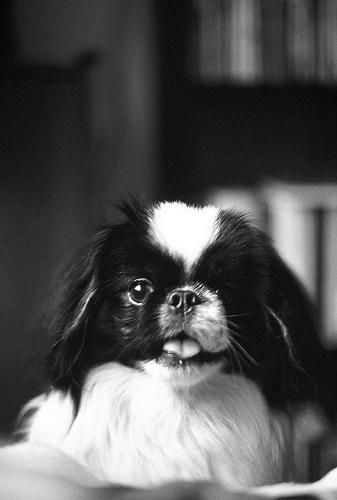

In [24]:
img = Image.open(path/'bnw/test.jpg')
img

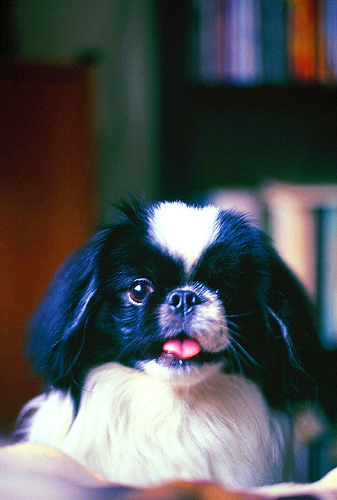

In [25]:
img = Image.open(files[0])
img

In [38]:
il = ImageList.from_folder(path_hr)
parallel(BlackNWhite(path_bw, path_hr), il.items)

In [41]:
bw_files = get_image_files(path_bw)
bw_files[:4]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/bw/japanese_chin_71.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/bw/great_pyrenees_136.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/bw/japanese_chin_64.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/bw/Bengal_193.jpg')]

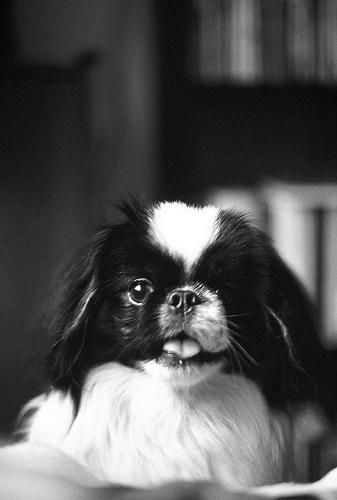

In [42]:
img = Image.open(bw_files[0])
img

In [0]:
bs,size=32, 128
arch = models.resnet34

In [0]:
arch = models.resnet34
src = ImageImageList.from_folder(path_bw).split_by_rand_pct(0.1, seed=42)

In [0]:

def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

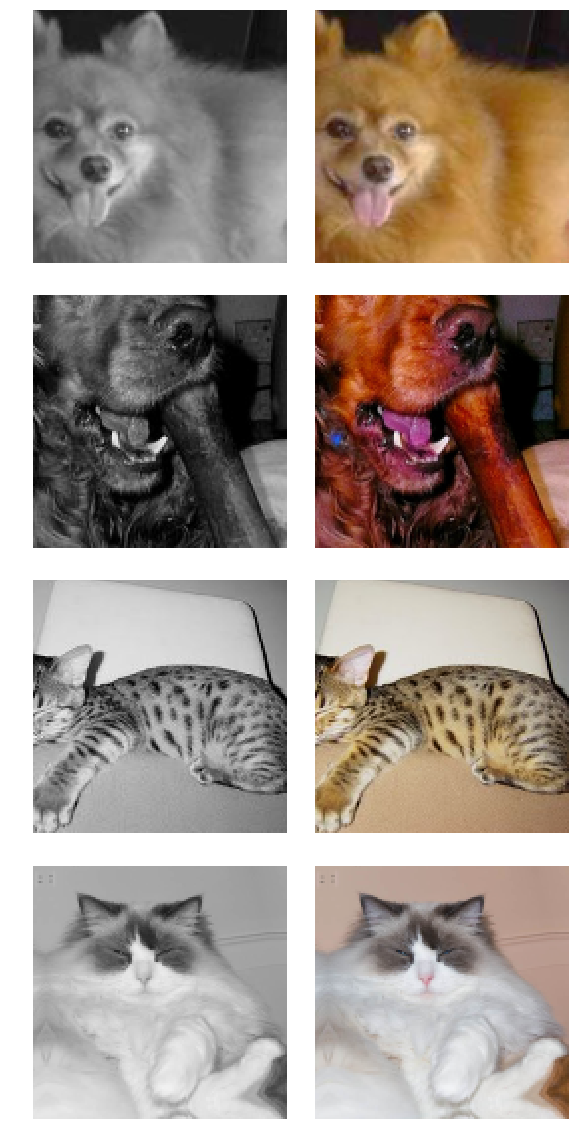

In [47]:
data_gen.show_batch(4)

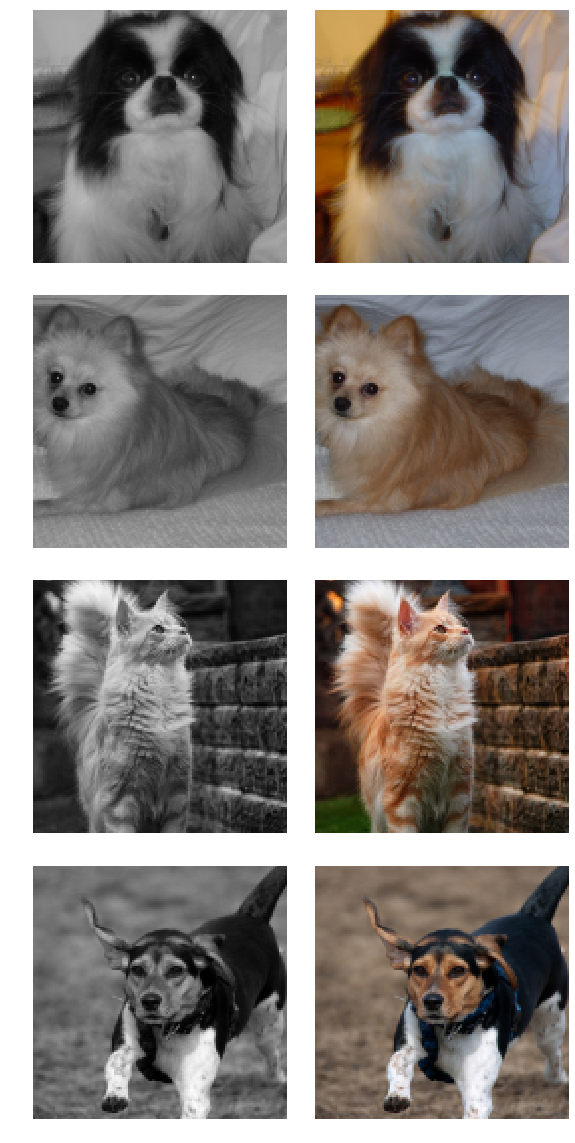

In [48]:
data_gen.show_batch(4, ds_type=DatasetType.Valid)

In [0]:
wd = 1e-3

y_range = (-3.,3.)

In [0]:
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=False, norm_type=NormType.Weight,
                        self_attention=True, y_range=y_range, loss_func=loss_gen)

In [53]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 100855538.56it/s]


In [54]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.110116,0.096703,04:08
1,0.094268,0.088770,03:40


In [0]:
learn_gen.unfreeze()

In [56]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.093001,0.092451,03:37
1,0.084412,0.085824,03:34
2,0.085142,0.083801,03:30


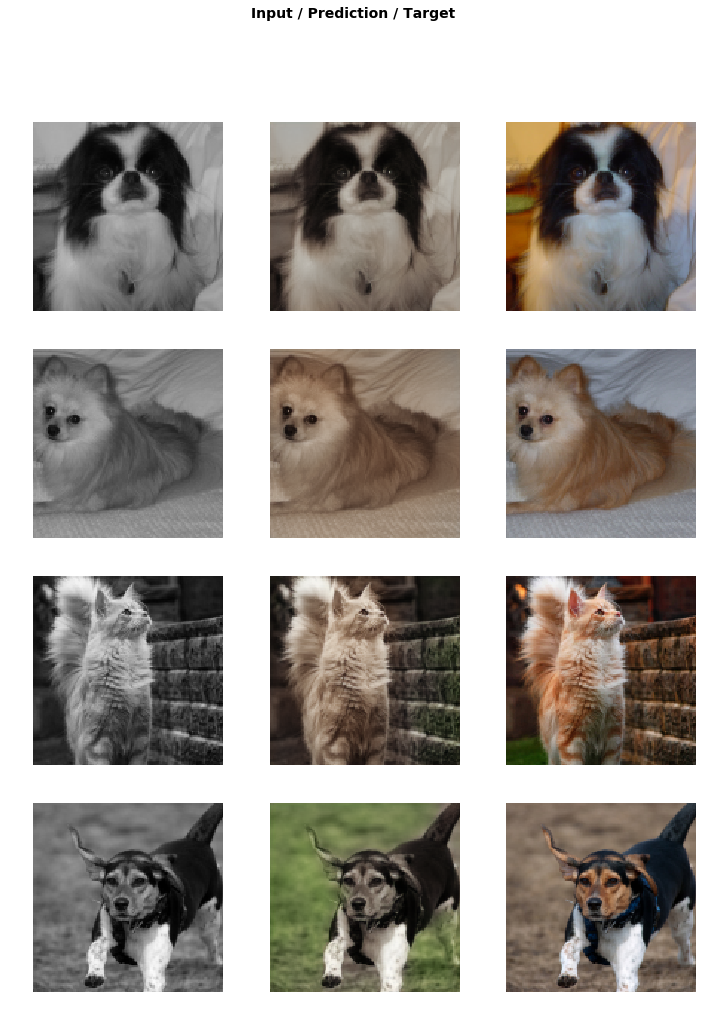

In [57]:
learn_gen.show_results(rows=4)

In [0]:
learn_gen.save('gen-pre2')

In [0]:
learn_gen.load('gen-pre2');

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i = 0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

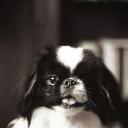

In [65]:
PIL.Image.open(path_gen.ls()[0])

In [66]:
learn_gen=None
gc.collect()

7

In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

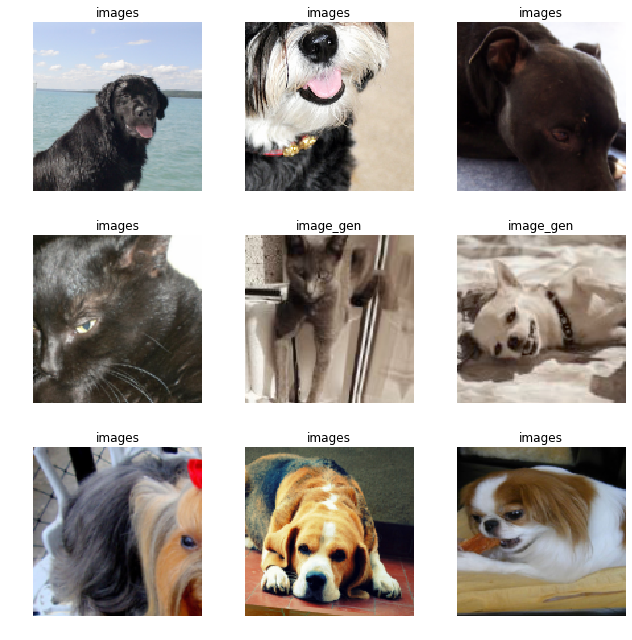

In [70]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [75]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.272930,0.210106,0.926952,07:00
1,0.142482,0.122726,0.960085,06:52
2,0.122188,0.089217,0.972991,06:51
3,0.092049,0.064280,0.979117,06:50
4,0.070610,0.050789,0.983533,06:49
5,0.067344,0.049259,0.984188,06:50


In [0]:
learn_critic.save('critic-pre2')

In [78]:
learn_crit=None
learn_gen=None
gc.collect()

20685

In [0]:
data_crit = get_crit_data(['bw', 'images'], bs=bs, size=size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [0]:
learn_gen = create_gen_learner().load('gen-pre2')

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

In [0]:

learn.fit(40,lr)

In [0]:
learn.save('gan-1c')

In [0]:
learn.data=get_data(16,192)

In [0]:
learn.fit(10,lr/2)

In [0]:
learn.show_results(rows=16)